In [87]:
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [3]:
df = pd.read_csv('../data/State_of_data_BR_2023_Kaggle - df_survey_2023.csv')

## Columns dictionary

In [4]:
df.columns[:10]

Index(['('P0', 'id')', '('P1_a ', 'Idade')', '('P1_a_1 ', 'Faixa idade')',
       '('P1_b ', 'Genero')', '('P1_c ', 'Cor/raca/etnia')',
       '('P1_d ', 'PCD')', '('P1_e ', 'experiencia_profissional_prejudicada')',
       '('P1_e_1 ', 'Não acredito que minha experiência profissional seja afetada')',
       '('P1_e_2 ', 'Experiencia prejudicada devido a minha Cor Raça Etnia')',
       '('P1_e_3 ', 'Experiencia prejudicada devido a minha identidade de gênero')'],
      dtype='object')

In [5]:
# criando um dicionário com o número da pergunta e qual é a pergunta
column_dict = {}

for col in df.columns:

    match = re.match(r"\('(.+?)', '(.+?)'\)", col)
    if match:
        cod, pergunta = match.groups()
        column_dict[cod.replace(" ", "")] = pergunta
    else:
        print(col)

# print(column_dict)

('P6_b_16 ', 'SQL Server Integration Services (SSIS))


In [6]:
column_dict['P6_b_16']='SQL Server Integration Services (SSIS)'

In [7]:
df_recols = df.copy()
df_recols.columns = list(column_dict.keys())

In [8]:
df_recols.columns

Index(['P0', 'P1_a', 'P1_a_1', 'P1_b', 'P1_c', 'P1_d', 'P1_e', 'P1_e_1',
       'P1_e_2', 'P1_e_3',
       ...
       'P8_d_4', 'P8_d_5', 'P8_d_6', 'P8_d_7', 'P8_d_8', 'P8_d_9', 'P8_d_10',
       'P8_d_11', 'P8_d_12', 'P6_b_16'],
      dtype='object', length=399)

# Balanceando classes sensíveis com data augmentation
Observação: esse tratamento só deve ser aplicado na base de treino!!

##  Gênero (P1_b)
Para entender se é necessário balancear pelo gênero, é importante entender se a variável resposta tem distinção entre as classes dessa feature

In [9]:
df_recols.P1_b.unique()

array(['Masculino', 'Feminino', 'Outro', 'Prefiro não informar'],
      dtype=object)

In [10]:
salario_fem = df_recols.loc[lambda x: x.P1_b=='Feminino', ['P2_h', 'P2_o_1']]
salario_outros = df_recols.loc[lambda x: (x.P1_b=='Outro') | (x.P1_b=='Prefiro não informar'), ['P2_h', 'P2_o_1']]

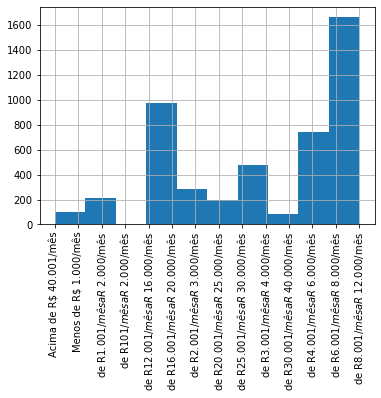

In [11]:
df_recols.P2_h.sort_values().hist();
plt.xticks(rotation=90)
plt.show()

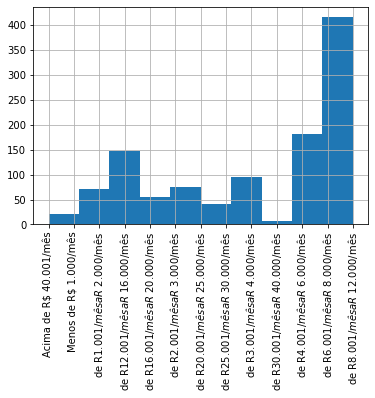

In [12]:
# faixa salarial - mulheres
salario_fem.P2_h.sort_values().hist();
plt.xticks(rotation=90)
plt.show()

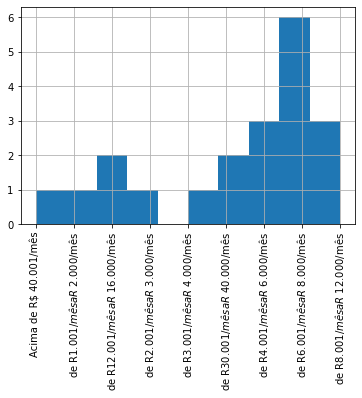

In [13]:
# faixa salarial - outros gêneros
salario_outros.P2_h.sort_values().hist();
plt.xticks(rotation=90)
plt.show()

Qualitativamente a distribuição com a variável resposta não parece ter grande diferença entre gêneros. Podemos avaliar o resultado do modelo, se tem distinção entre classes na previsão.

## Raça

In [14]:
df_recols.P1_c.unique()

array(['Branca', 'Amarela', 'Preta', 'Parda', 'Prefiro não informar',
       'Outra', 'Indígena'], dtype=object)

In [30]:
col_raca = 'P1_c'
col_salario = 'P2_h'

In [15]:
# df_recols[['P1_c','P2_h']].groupby('P1_c')

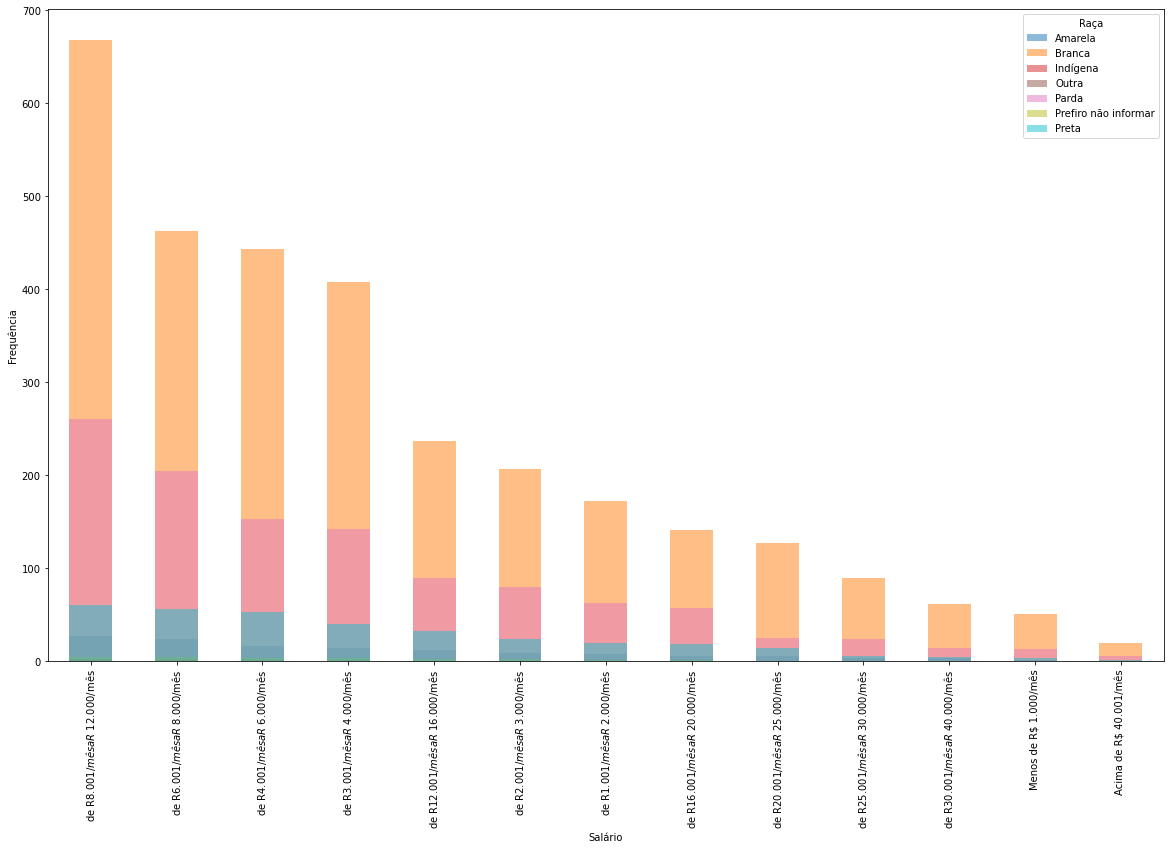

In [16]:

cores = plt.cm.get_cmap('tab10', len(df_recols['P1_c'].unique()))

plt.figure(figsize=(20, 12))
# Agrupar por nome e plotar as faixas etárias
for i, (raca, salario) in enumerate(df_recols[['P1_c','P2_h']].groupby('P1_c')):
    salario['P2_h'].value_counts().plot(kind='bar', alpha=0.5, label=raca, color=cores(i))
    
plt.xlabel('Salário')
plt.ylabel('Frequência')
plt.legend(title="Raça")
plt.xticks(rotation=90)
plt.show()

As raças Preta, Indígena e Outros estão muito sub-representados. A raça Preta é pouco visível no gráfico e somente para baixos salários. Um re-sampling aqui pode contribuir

## Random Oversampling
- SMOTE
- Adasyn (Adaptive Synthetic Sampling)
- Random Oversampling: método que lida melhor com categóricas e não remove as características da classe

**Considerações**:
- Vou agrupar Indígenas, Outras e Prefiro não informar
- Fazer um oversampling do tamanho da amostra de pessoas brancas é muito grande e deixa o dataset muito sintético. Farei baseado no tamanho da amostra de pessoas pardas. 
- É simples de mudar para Adasyn se tudo estiver encodado

In [17]:
df_recols.loc[lambda x: (x.P1_c=='Indígena') | (x.P1_c=='Outra') | (x.P1_c=='Prefiro não informar'), 'P1_c'] = 'Outros agrupado'

In [37]:
df_recols[lambda x: (x[col_raca]=='Parda')].reset_index().shape[0]

1281

In [32]:
df_parda = df_recols[lambda x: (x[col_raca]=='Parda')].reset_index()
df_branca = df_recols[lambda x: (x[col_raca]=='Branca')].reset_index()
df_to_oversample = df_recols[lambda x: (x[col_raca]!='Parda') & (x[col_raca]!='Branca')].reset_index()

In [43]:
# 1. Separar as features (X) e a coluna alvo (raca)
X = df_recols.drop(columns=[col_raca])  # Todas as colunas exceto 'raca'
y = df_recols[col_raca]  # Coluna alvo

# setando numero de amostras para cada raça - precisa ser o valor da classe com mais repetições
# sampl_stratg = {el: y.value_counts()['Parda'] for el in list(set(y))}

# 2. Aplicar o RandomOverSampler para realizar oversampling na coluna 'raca'
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Recriar o DataFrame com os dados balanceados
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['raca'] = y_resampled

# Exibir o DataFrame balanceado
print(df_resampled['raca'].value_counts())


Branca             3414
Amarela            3414
Preta              3414
Parda              3414
Outros agrupado    3414
Name: raca, dtype: int64


______
Para as demais variáveis, o processo será parecido. Vamos deixar funções preparadas para:
- Undersampling ou separação de uma classe majoritária
- Aplicar random oversampling

In [88]:
def apply_random_undersampling(df, undersample_col='', strategy={}):
    '''
    df: dataframe with all columns
    undersample_col: column to apply the undersampling
    srtategy: dictionary with the category as key and number of samples requested as value
    '''

    X = df.drop(columns=[undersample_col])
    y = df[undersample_col]

    # aplicando undersampling
    undersampler = RandomUnderSampler(sampling_strategy=strategy, random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[undersample_col] = y_resampled

    # Exibir o DataFrame balanceado e a distribuição de classes
    print(df_resampled[undersample_col].value_counts())
    
    return df_resampled

In [89]:
strategy = {'Branca': 1000}
df_raca_undersampled = apply_random_undersampling(df_recols, undersample_col=col_raca, strategy=strategy)

Parda              1281
Branca             1000
Preta               387
Amarela             147
Outros agrupado      64
Name: P1_c, dtype: int64


In [78]:
def apply_random_oversampling(df, oversample_col='', exclude_category=None):
    '''
    df: dataframe with all columns
    oversample_col: column to apply the oversampling
    exclude_category: list of categories on oversample_col to set apart while oversampling
    '''
    df_cat = pd.DataFrame(columns = df.columns)
    df_ = df.copy()
    
    # Separando categorias específica se necessário
    if exclude_category is not None:
        
        for cat in exclude_category:
            
            df_cat = pd.concat([df_cat, df[df[oversample_col]==cat]]).reset_index(drop=True)
            
            # removendo categorias que não serão oversampled
            df_ = df_[df[oversample_col]!=cat].reset_index()
    
    # Separando coluna de oversampling
    X = df_.drop(columns=[oversample_col])
    y = df_[oversample_col]

    # Aplicando Random Oversampling
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[oversample_col] = y_resampled

    # Exibir o DataFrame balanceado
    print(df_resampled[oversample_col].value_counts())
    
    # inserindo de volta as categorias que foram separadas
    if not df_cat.empty:
        df_resampled = pd.concat([df_resampled, df_cat]).reset_index(drop=True)
        
    return df_resampled

In [79]:
col_raca

'P1_c'

In [80]:
df_raca_resampled = apply_random_oversampling(df_recols, oversample_col=col_raca, exclude_category=['Branca'])
df_raca_resampled

Amarela            1281
Preta              1281
Parda              1281
Outros agrupado    1281
Name: P1_c, dtype: int64


,index,P0,P1_a,P1_a_1,P1_b,P1_d,P1_e,P1_e_1,P1_e_2,P1_e_3,...,P8_d_6,P8_d_7,P8_d_8,P8_d_9,P8_d_10,P8_d_11,P8_d_12,P6_b_16,faixa_salario_cat,P1_c
0,2.0,00r21rb9pusd1b0v7ew00r21rw3dy69w,37,35-39,Feminino,Não,"Sim, acredito que a minha a experiência profis...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,Amarela
1,3.0,00urm3jf2cek12w6ygue00urm3jzd17j,22,22-24,Masculino,Não,Não acredito que minha experiência profissiona...,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,Preta
2,8.0,01n9nd73iv68k81iefenxv01n9nd7wjt,27,25-29,Masculino,Não,Não acredito que minha experiência profissiona...,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,Parda
3,9.0,01v9nqn7mz93ace01v9ig2aswc6oy2zq,28,25-29,Masculino,Não,Não acredito que minha experiência profissiona...,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,Parda
4,10.0,01zusm1faol2k2601zlthh05cj7iqyit,25,25-29,Masculino,Sim,"Sim, acredito que a minha a experiência profis...",0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Preta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8533,NaN,zxvqqx4k2pmcnx45vy4wzxvqdzq0exzh,34,30-34,Masculino,Não,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,Branca
8534,NaN,zy2x71m6qqffo5th4t8zy2x713efewf5,37,35-39,Masculino,Não,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,Branca
8535,NaN,zy7hsey7pigk6d4a4zy7hsm7bh1vcozc,28,25-29,Masculino,Não,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,Branca
8536,NaN,zyppgxzxko25qkgwsbrgpzyppgxzxs81,32,30-34,Masculino,Não,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13,Branca


# Idade
A idade vai estar altamente relacionada com o salário. Dado o contexto, isso é um problema?

In [48]:
col_faixaidade = 'P1_a_1'

# Região

In [84]:
col_regiao = 'P1_i_2'

# Auxiliar

In [41]:
column_dict.values()

dict_values(['id', 'Idade', 'Faixa idade', 'Genero', 'Cor/raca/etnia', 'PCD', 'experiencia_profissional_prejudicada', 'Não acredito que minha experiência profissional seja afetada', 'Experiencia prejudicada devido a minha Cor Raça Etnia', 'Experiencia prejudicada devido a minha identidade de gênero', 'Experiencia prejudicada devido ao fato de ser PCD', 'aspectos_prejudicados', 'Quantidade de oportunidades de emprego/vagas recebidas', 'Senioridade das vagas recebidas em relação à sua experiência', 'Aprovação em processos seletivos/entrevistas', 'Oportunidades de progressão de carreira', 'Velocidade de progressão de carreira', 'Nível de cobrança no trabalho/Stress no trabalho', 'Atenção dada diante das minhas opiniões e ideias', 'Relação com outros membros da empresa, em momentos de trabalho', 'Relação com outros membros da empresa, em momentos de integração e outros momentos fora do trabalho', 'vive_no_brasil', 'Estado onde mora', 'uf onde mora', 'Regiao onde mora', 'Mudou de Estado?', 

In [44]:
def search_question(q):
    for cod, question in column_dict.items(): 
        if question == q:
            return cod
    return None

In [12]:
faixa = search_question('Faixa salarial')
valor = search_question('Remuneração/Salário')
faixa, valor

('P2_h', 'P2_o_1')

In [42]:
cor = search_question('Cor/raca/etnia')
cor

'P1_c'

In [46]:
idade = search_question('Idade')
idade

'P1_a'

In [47]:
f_idade = search_question('Faixa idade')
f_idade

'P1_a_1'

In [83]:
col_regiao = search_question('Regiao onde mora')
col_regiao

'P1_i_2'